### 📦 1 | Install & Import Required Packages
---

**1.1 | Install Required Packages**

In [1]:
!pip install biopython
!pip install plotnine

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 12.1 MB/s eta 0:00:00


**1.2 | Import Required Packages**

In [7]:
from    Bio import Entrez
import  pandas as pd
from    datetime import datetime
from    plotnine import *
from    mizani.formatters import comma_format, percent_format

### 🚰  2 | Query PubMed API for Publication Counts
---

In [3]:
def fetch_pubmed_data_for_multiple_terms(search_terms, start_year, end_year):
    """
    Fetches publication counts from PubMed for multiple search terms over a range of years.

    :param search_terms: Dictionary of search terms (diseases) and their PubMed query strings.
    :param start_year: Start year for the data collection.
    :param end_year: End year for the data collection.
    :return: DataFrame with years as rows and diseases as columns, containing publication counts.
    """
    publication_counts = {term: [] for term in search_terms}
    years = range(start_year, end_year + 1)
    Entrez.email = "rory@eudemo.co"

    for year in years:
        for term, query in search_terms.items():
            # Constructing the query with the search term and year
            full_query = f"{query} AND ({year}[Date - Publication])"
            handle = Entrez.esearch(db="pubmed", term=full_query, retmax=100000)
            record = Entrez.read(handle)
            count = int(record["Count"])
            publication_counts[term].append(count)
            handle.close()

    # Creating a DataFrame from the collected data
    df = pd.DataFrame(publication_counts, index=years)
    df.index.name = 'Year'
    return df

# Define the search terms for each disease
search_terms = {
    "Long Covid Only": "(Long Covid) NOT (ME/CFS OR Myalgic Encephalomyelitis OR Chronic Fatigue Syndrome OR CFS/ME)",
    "Long Covid & ME/CFS": "(ME/CFS OR Myalgic Encephalomyelitis OR Chronic Fatigue Syndrome OR CFS/ME) AND (Long Covid)"
}

# Define the start and end years for the search
start_year = 2020
end_year = 2023

# Fetching the data (to be executed in an environment where Biopython is installed)
publications_df = fetch_pubmed_data_for_multiple_terms(search_terms, start_year, end_year)

# Check result
publications_df.tail()

,Long Covid Only,Long Covid & ME/CFS
Year,,
2020,4301,13
2021,9318,123
2022,10867,190
2023,8796,237


In [4]:
# Transforming the DataFrame to long format
long_df = publications_df.reset_index().melt(id_vars='Year', var_name='Disease', value_name='Publications')

# Calculate the total publications per year for normalization
long_df['Total'] = long_df.groupby('Year')['Publications'].transform('sum')

# Calculate the percentage of publications for each category per year
long_df['Percentage'] = 100 * long_df['Publications'] / long_df['Total']

# Check result
long_df

,Year,Disease,Publications,Total,Percentage
0,2020,Long Covid Only,4301,4314,99.698656
1,2021,Long Covid Only,9318,9441,98.697172
2,2022,Long Covid Only,10867,11057,98.281632
3,2023,Long Covid Only,8796,9033,97.376287
4,2020,Long Covid & ME/CFS,13,4314,0.301344
5,2021,Long Covid & ME/CFS,123,9441,1.302828
6,2022,Long Covid & ME/CFS,190,11057,1.718368
7,2023,Long Covid & ME/CFS,237,9033,2.623713


### 📈  3 | Visualise Results
---

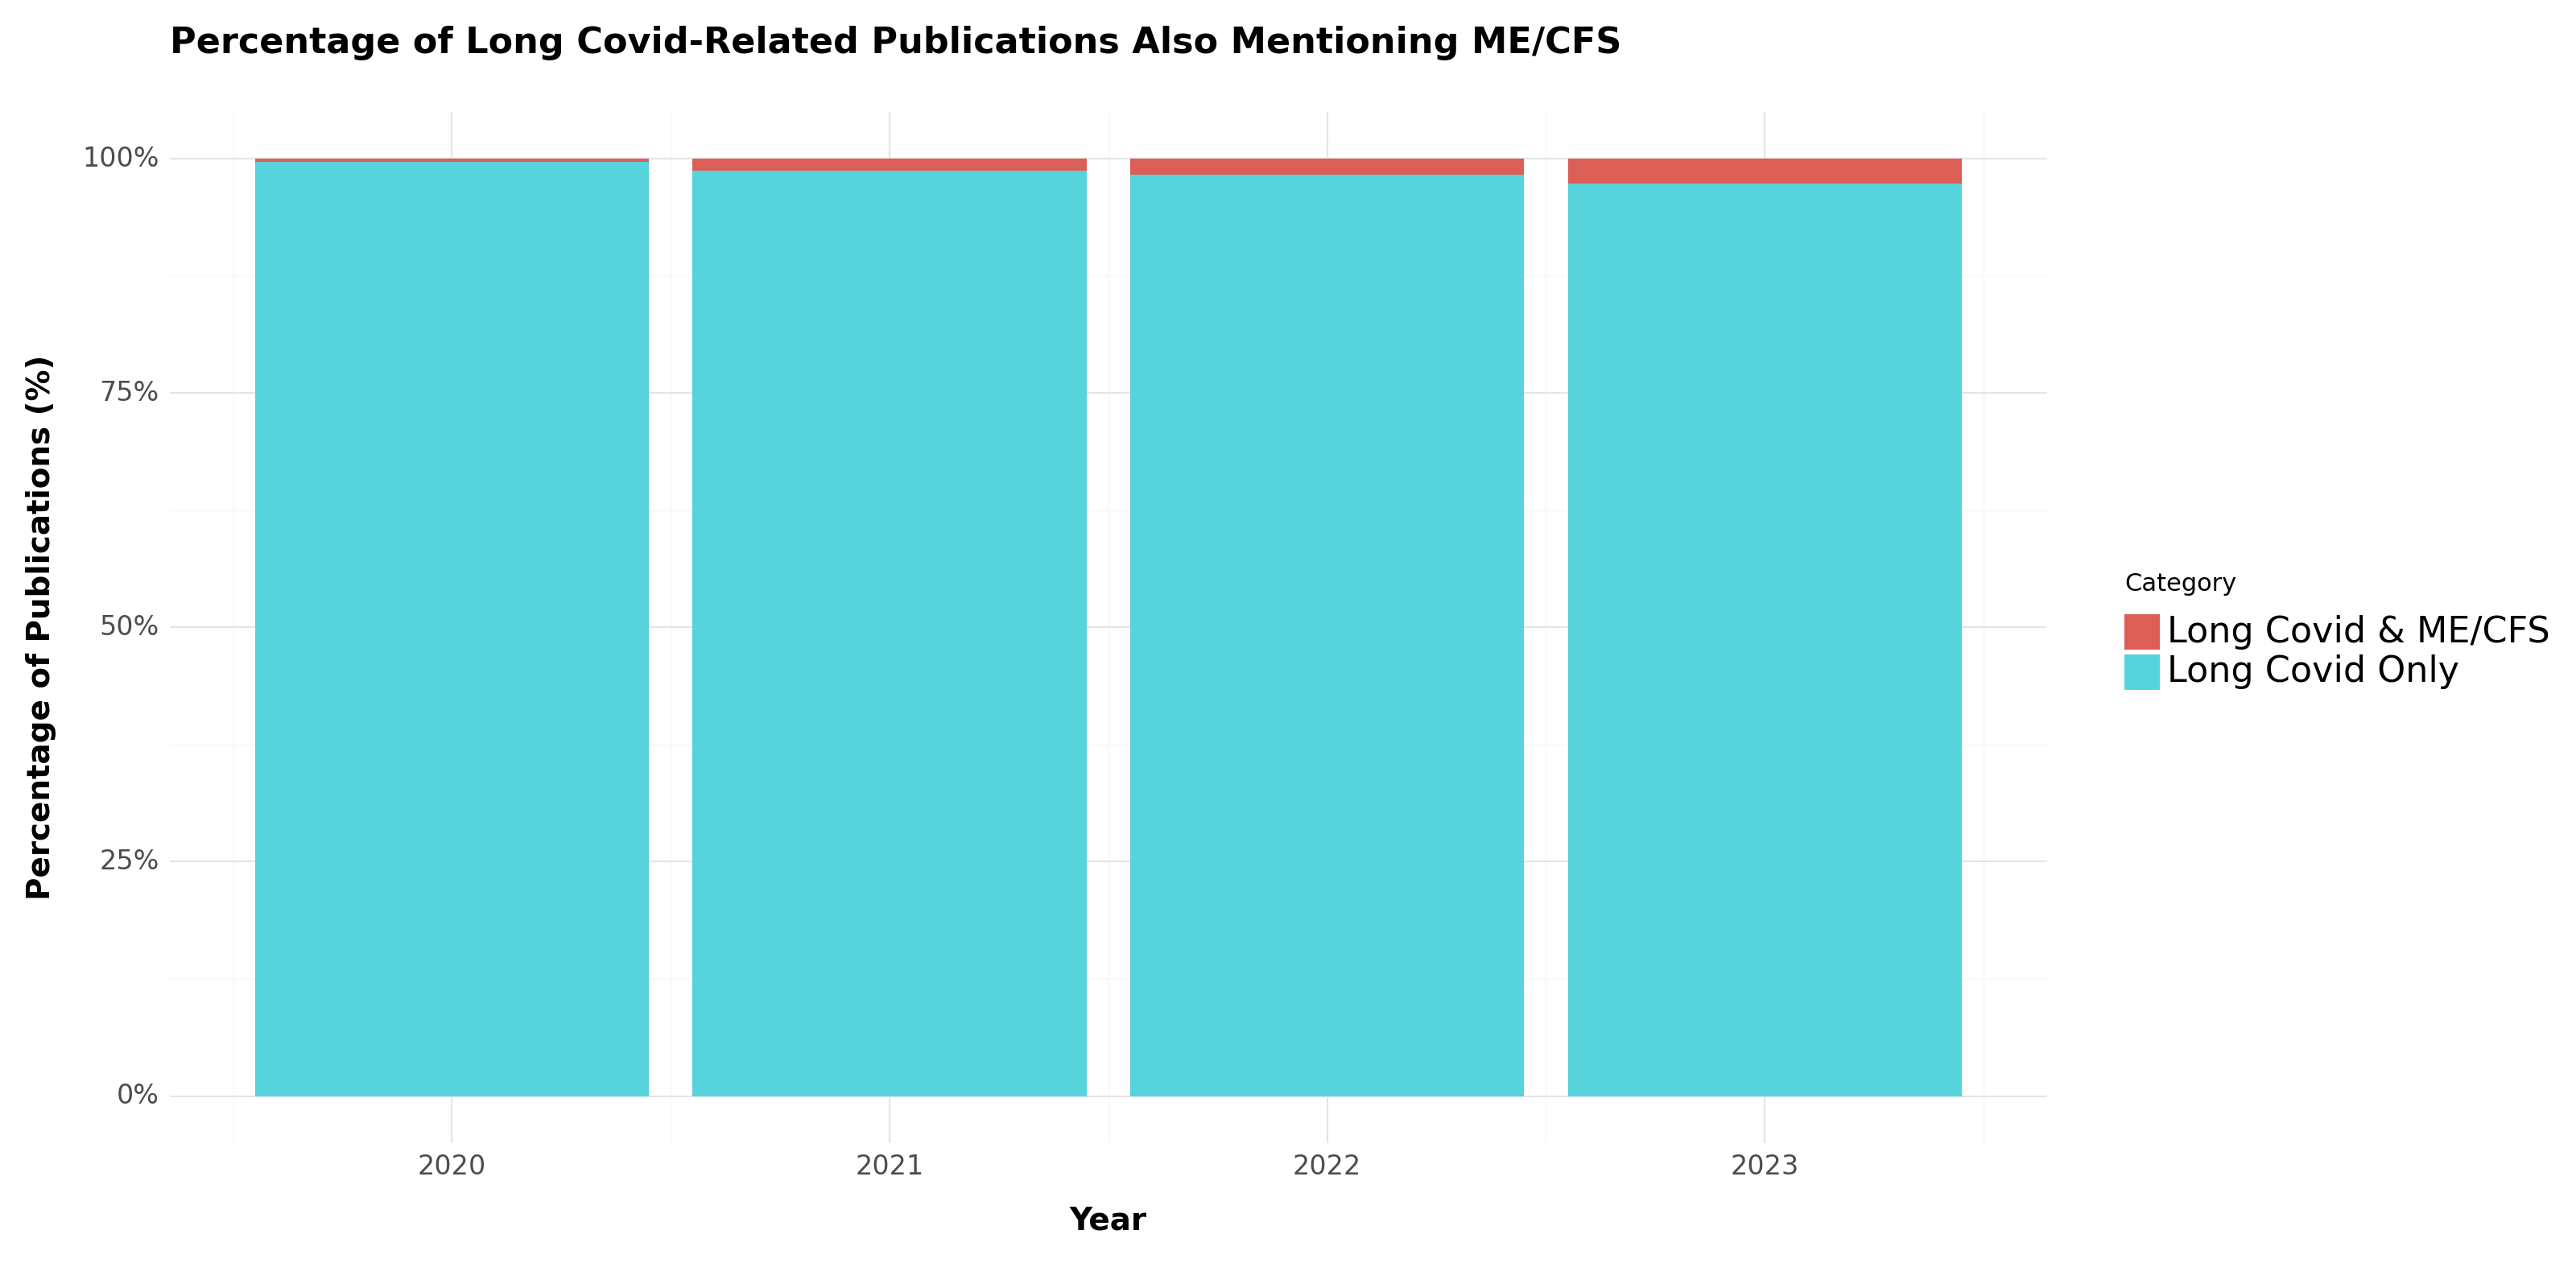

In [9]:
# Create a percentage stacked bar chart using plotnine, with y-axis as percentages
plot = (ggplot(long_df, aes(x='Year', y='Percentage', fill='Disease'))
        + geom_bar(stat='identity', position='fill')  # Stacks percentage for each category
        + labs(x='Year', y='Percentage of Publications (%)', fill='Category', title='Percentage of Long Covid-Related Publications Also Mentioning ME/CFS')
        + scale_y_continuous(labels=percent_format())  # Convert y-axis to percentage format
        + theme_minimal()
        + theme(figure_size=(16, 8),
              axis_title=element_text(size=14, weight='bold'),
              axis_text=element_text(size=12),
              plot_title=element_text(size=16, weight='bold'),
              legend_text=element_text(size=16))
        )

# Display the plot
print(plot)